In [1]:
%%capture
import math
import pickle
import matplotlib
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
from stargazer.stargazer import Stargazer
from scipy import stats
from scipy.stats import ttest_1samp
from datetime import timedelta, datetime, time, date
from matplotlib import rc
from tqdm.notebook import tqdm
from IPython.display import display, HTML
from cycler import cycler
tqdm().pandas()

color_list = ["#348ABD","#A60628","#7A68A6","#467821","#CF4457","#188487","#E24A33"]
style = {
  "lines.linewidth": 2.0,
  "axes.edgecolor": "#bcbcbc",
  "patch.linewidth": 0.5,
  "legend.fancybox": True,
  "axes.prop_cycle": cycler('color', color_list),
  "axes.facecolor": "#ffffff",
  "axes.labelsize": "large",
  "axes.grid": True,
  "patch.edgecolor": "#eeeeee",
  "axes.titlesize": "x-large",
  "svg.fonttype": "path"}

matplotlib.rcParams.update(style)

# Modify pandas display settings
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 30)

data_path    = "C:/Users/Stefa/Documents/Uni/Projektassistenz/Python/Data/"
output_path  = "C:/Users/Stefa/Documents/Uni/Projektassistenz/Auswertung/"
fin_data     = "C:/Users/Stefa/Documents/Uni/Projektassistenz/Financial Data/"

Load Data

In [2]:
sp500 = pd.read_csv(fin_data+'SPCOMP_1994_2022.csv', sep=';', index_col=0)
sp500.index = pd.to_datetime(sp500.index) 
sp500['TOT RETURN OPEN'] = (sp500['OPENING PRICE']/sp500['PRICE INDEX'])*sp500['TOT RETURN IND']
sp500_r = sp500.pct_change()  
sp500_r['TR OpenClose'] = (sp500['TOT RETURN IND']  - sp500['TOT RETURN OPEN'])/sp500['TOT RETURN OPEN']
sp500_r['TR CloseOpen'] = (sp500['TOT RETURN OPEN'] - sp500['TOT RETURN IND'].shift(1))/sp500['TOT RETURN IND'].shift(1)
sp500_r = sp500_r.reset_index()

vix = pd.read_csv("C:/Users/Stefa/Documents/Uni/Projektassistenz/Financial Data/VIX.csv", encoding="utf-8")
vix.date = pd.to_datetime(vix.date)
vix = vix.rename(columns={'date':'Date'})
vix['vix_tm1'] = vix.vix.shift(1)

# Load Fama Frensh Data
fama_french = pd.read_csv(fin_data+'F-F_Research_Data_5_Factors_2x3_daily.csv', header=2, encoding='utf-8', index_col=0)
fama_french.index = pd.to_datetime(fama_french.index, format='%Y%m%d')
fama_french.index.name = 'Date'
fama_french = fama_french.rename(columns={'Mkt-RF':'Mkt_RF'})
fama_french = fama_french.loc[datetime(1995,12,28):]
fama_french = fama_french/100

beta = pd.read_csv(fin_data+'beta_mc_to_mc_df_2022.csv')     
beta.Date = pd.to_datetime(beta.Date)
beta = beta.set_index('Date')
beta = beta.stack()
beta = beta.reset_index()
beta.columns = ['Date', 'Ticker', 'Beta']

In [3]:
idiosync_returns = True
idiosync = '_idiosync' if idiosync_returns else ''
abn      = '_abn' if idiosync_returns else '' 

r_mo_to_mo = pd.read_csv(fin_data + f"Datastream/Data/return_mo_to_mo{idiosync}.csv", index_col=0)                 
r_mo_to_mo.index = pd.to_datetime(r_mo_to_mo.index)                                                        
r_mo_to_mo = r_mo_to_mo.replace([np.inf, -np.inf, 0.00000], np.nan)
r_mo_to_mo = r_mo_to_mo.reset_index()
r_mo_to_mo.insert(0, 'Date_tm1', r_mo_to_mo.Date)
r_mo_to_mo.loc[:, 'Date':] = r_mo_to_mo.loc[:, 'Date':].shift(-1)
r_mo_to_mo = r_mo_to_mo.drop(['Date'], axis=1)
r_mo_to_mo = r_mo_to_mo.set_index('Date_tm1')
r_mo_to_mo = r_mo_to_mo.stack()
r_mo_to_mo.index.names = ['Date', 'Ticker']
r_mo_to_mo.name = 'return_mo_to_mo_t'

event_data = pd.read_csv(f'./Data/event_data{abn}_returns_mo_to_mc_17_5h_z_val_idiosync_no_dupl_2002-2021_v2.csv', encoding='utf-8')
event_data.Date = pd.to_datetime(event_data.Date)
event_data = event_data.set_index('Date')

dataset = event_data.loc[:, ['Ticker', 'z_value', 'Sentiment', 'return_t', 'topic_1', 'topic_2']]
dataset = dataset.rename(columns={'return_t':'return_mo_to_mc_t'})
dataset = dataset.set_index('Ticker', append=True)
dataset = pd.merge(left=dataset, right=r_mo_to_mo, left_index=True, right_index=True, how='left')
dataset = dataset.reset_index()
dataset = pd.merge(left=dataset, right=vix[['Date', 'vix_tm1']], on='Date', how='left')
dataset = pd.merge(left=dataset, right=sp500_r[['Date', 'TR CloseOpen']], on='Date', how='left')
dataset = dataset.rename(columns={'z_value':'z_value_tm1'})

In [8]:
# Dataset with duplicate news of one compay during the overnight period
news_event_df = pd.read_csv('./Data/news_event_df.csv', encoding='utf-8')
news_event_df.Timestamp_ET = pd.DatetimeIndex(news_event_df.Timestamp_ET)
news_event_df.TradingDate = pd.to_datetime(news_event_df.TradingDate)
news_event_df.Date = pd.to_datetime(news_event_df.Date)
news_event_df = news_event_df.set_index(['Timestamp_ET', 'Ticker'])

sel_overnight_news = ((news_event_df.index.get_level_values(0).time > time(9,30)) &
                      (news_event_df.index.get_level_values(0).time < time(16,0))) ==False

dataset2 = news_event_df.loc[sel_overnight_news].reset_index()
dataset2 = dataset2.set_index(['TradingDate', 'Ticker'])
dataset2.index.names = ['Date', 'Ticker']
dataset2 = pd.merge(left=dataset2, right=r_mo_to_mo, left_index=True, right_index=True, how='left')
dataset2['z_value_tm1'] = 0
dataset2 = dataset2.drop(['Date'], axis=1)
dataset2 = dataset2.reset_index()

In [474]:
dataset2.head()

,Date,Ticker,Timestamp_ET,Sentiment,freshness,topic_1,topic_2,topic_3,topic_4,return_mo_to_mo_t,z_value_tm1
0,2002-01-03,APA,2002-01-03 07:37:06.469,-0.979454,fresh,0.265517,0.129310,0.0,0.0,-0.020584,0
1,2002-01-03,BAX,2002-01-03 02:04:46.350,0.007018,fresh,0.124138,0.146552,0.0,0.0,-0.009504,0
2,2002-01-03,CSCO,2002-01-03 06:28:40.053,0.986660,fresh,0.000000,0.000000,0.0,0.0,0.057427,0
3,2002-01-03,DOW,2002-01-03 08:09:05.289,0.997269,fresh,0.289655,0.405172,0.0,0.0,0.042021,0
4,2002-01-03,EMC,2002-01-03 09:13:16.217,0.993540,fresh,0.413793,0.000000,0.0,0.0,0.054444,0


In [533]:
def TradingStrategy(df, strategy, sCrit=0.45, zCrit=1.2):   
    if strategy == 'reversal':
        trading_data = df.loc[((abs(df.z_value_tm1) >= zCrit) & (abs(df.Sentiment) >= sCrit)),:].copy()
        trading_data['enter_long'], trading_data['enter_short'] = 0, 0
        trading_data.loc[trading_data.z_value_tm1 > 0, 'enter_short'] = 1
        trading_data.loc[trading_data.z_value_tm1 < 0, 'enter_long']  = 1
    
    elif strategy == 'analyst_foreast':
        trading_data = df.loc[((abs(df.z_value_tm1) >= zCrit) & (abs(df.Sentiment) >= sCrit)),:].copy()
        trading_data['enter_long'], trading_data['enter_short'] = 0, 0
        trading_data.loc[((trading_data.topic_1 > 0.15) & (trading_data.Sentiment > 0)), 'enter_long']  = 1
        trading_data.loc[((trading_data.topic_1 > 0.15) & (trading_data.Sentiment < 0)), 'enter_short'] = 1
        
    elif strategy == 'sentiment':
        trading_data = df.loc[((abs(df.z_value_tm1) >= zCrit) & (abs(df.Sentiment) >= sCrit)),:].copy()
        trading_data['enter_long'], trading_data['enter_short'] = 0, 0
        trading_data.loc[trading_data.Sentiment > 0, 'enter_long']  = 1
        trading_data.loc[trading_data.Sentiment < 0, 'enter_short'] = 1  
        
    elif strategy == 'shortReversal_longSentiment':
        trading_data = df.loc[abs(df.Sentiment) >= sCrit,:].copy()
        trading_data['enter_long'], trading_data['enter_short'] = 0, 0
        trading_data.loc[((trading_data.Sentiment >= sCrit) & (trading_data.z_value_tm1 < zCrit)), 'enter_long']    = 1
        trading_data.loc[trading_data.z_value_tm1 >= zCrit, 'enter_short'] = 1
        
    
    trading_data = trading_data.set_index('Date')
    return trading_data
        
    
#trading_data = TradingStrategy(dataset, 'reversal', sCrit=0.45, zCrit=0.5)
#trading_data = TradingStrategy(dataset, 'analyst_foreast', sCrit=0.45, zCrit=0.5)
#trading_data = TradingStrategy(dataset2, 'sentiment', sCrit=0.95, zCrit=0)
trading_data = TradingStrategy(dataset, 'shortReversal_longSentiment', sCrit=0.45, zCrit=0.5)

In [534]:
print(trading_data.shape)
trading_data.head()

(63093, 12)


,Ticker,z_value_tm1,Sentiment,return_mo_to_mc_t,topic_1,topic_2,return_mc_to_mo_t,return_mo_to_mo_t,vix_tm1,TR CloseOpen,enter_long,enter_short
Date,,,,,,,,,,,,
2002-01-10,AES,NaN,-0.945934,0.031525,0.251724,0.000000,-0.037030,0.024788,22.129999,-0.000734,0,0
2002-01-10,HAL,NaN,0.980014,-0.061245,0.000000,0.000000,0.013018,-0.066895,22.129999,-0.000734,0,0
2002-01-10,KSS,NaN,0.660985,0.008568,0.000000,0.254310,-0.010896,0.007002,22.129999,-0.000734,0,0
2002-01-10,LLY,NaN,0.966337,0.015732,0.000000,0.133621,0.003453,0.025223,22.129999,-0.000734,0,0
2002-01-10,CSCO,NaN,0.950438,0.005728,0.172414,0.245690,-0.000863,-0.018926,22.129999,-0.000734,0,0


In [535]:
n_weeks = len(trading_data['return_mo_to_mo_t'].resample('W').mean().index)

trades_per_week_long  = trading_data.enter_long.sum()/n_weeks
trades_per_week_short = trading_data.enter_short.sum()/n_weeks

print('trades_per_week_long:', trades_per_week_long)
print('trades_per_week_short:', trades_per_week_short)

trades_per_week_long: 23.49044585987261
trades_per_week_short: 19.31528662420382


In [546]:
max_weight       = 0.05    # Maximum weight of a single asset in the portfolio
max_exposure     = 1      # Maximum total exposure to the strategy
transaction_cost = 0#.001  # 10bp = 0.001

return_col = 'return_mo_to_mo_t'
dates = trading_data.index.unique()
cols_long  = [f'long_{i}'  for i in range(1,11)]
cols_short = [f'short_{i}' for i in range(1,11)]

portfolio  = pd.DataFrame(index  = dates, 
                          columns=['portf_return_long', 'portf_return_short', 'portf_return_long_short', 
                                   'invesment_ratio_long', 'invesment_ratio_short',
                                   'n_long', 'n_short']+cols_long+cols_short)

for t in dates:
    # Long
    sel_long  = ((trading_data.index==t)&(trading_data.enter_long==1))
    ticker_long = list(trading_data.loc[sel_long, 'Ticker'])
    n_long      = len(ticker_long)
    if n_long >= 1:
        weight_long = min([max_weight, max_exposure/n_long])
        ir_long     = n_long * weight_long
        ticker_long += [np.nan] * (10-len(ticker_long))
        portfolio.loc[t, 'portf_return_long']  = (trading_data.loc[sel_long, return_col] * weight_long).sum()
        portfolio.loc[t, 'portf_return_long'] -= transaction_cost * ir_long
        portfolio.loc[t, 'long_1':'long_10']   = ticker_long[:10]
        portfolio.loc[t, 'invesment_ratio_long'] = ir_long
        portfolio.loc[t, 'n_long'] = n_long
        
    # Short
    sel_short = ((trading_data.index==t)&(trading_data.enter_short==1))
    ticker_short  = list(trading_data.loc[sel_short, 'Ticker'])
    n_short       = len(ticker_short)
    if n_short >= 1:
        weight_short = min([max_weight, max_exposure/n_short])
        ir_short = n_short * weight_short
        ticker_short += [np.nan] * (10-len(ticker_short))
        portfolio.loc[t, 'portf_return_short']  = -(trading_data.loc[sel_short, return_col] * weight_short).sum()
        portfolio.loc[t, 'portf_return_short'] -= transaction_cost * ir_short
        portfolio.loc[t, 'short_1':'short_10']  = ticker_short[:10]
        portfolio.loc[t, 'invesment_ratio_short'] = ir_short
        portfolio.loc[t, 'n_short'] = n_short
        
    # Long/Short
    portfolio.loc[t, 'portf_return_long_short'] = portfolio.loc[t, 'portf_return_long'] + portfolio.loc[t, 'portf_return_short']
    
    

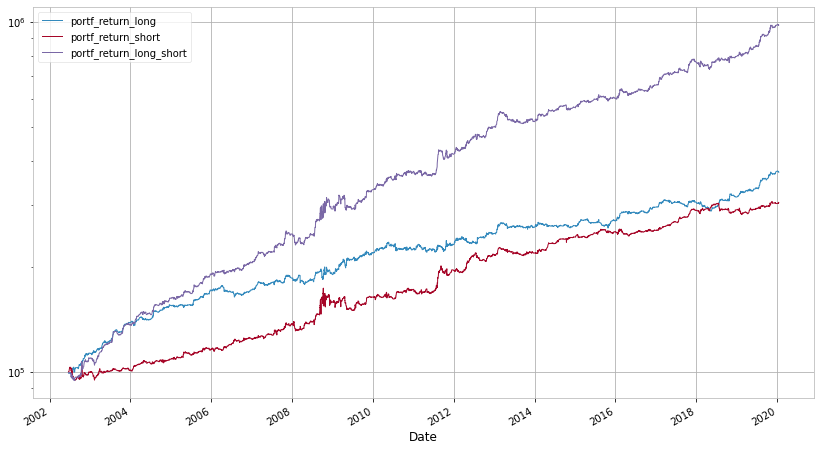

In [548]:
I0 = 100000  # Initial Capital

fig, ax = plt.subplots(figsize=(14,8))
(I0*(portfolio.portf_return_long.dropna()+1).cumprod()).plot(ax=ax, linewidth=1.0)
(I0*(portfolio.portf_return_short.dropna()+1).cumprod()).plot(ax=ax, linewidth=1.0)
(I0*(portfolio.portf_return_long_short.dropna()+1).cumprod()).plot(ax=ax, linewidth=1.0)

plt.legend()
plt.yscale('log')
plt.show()

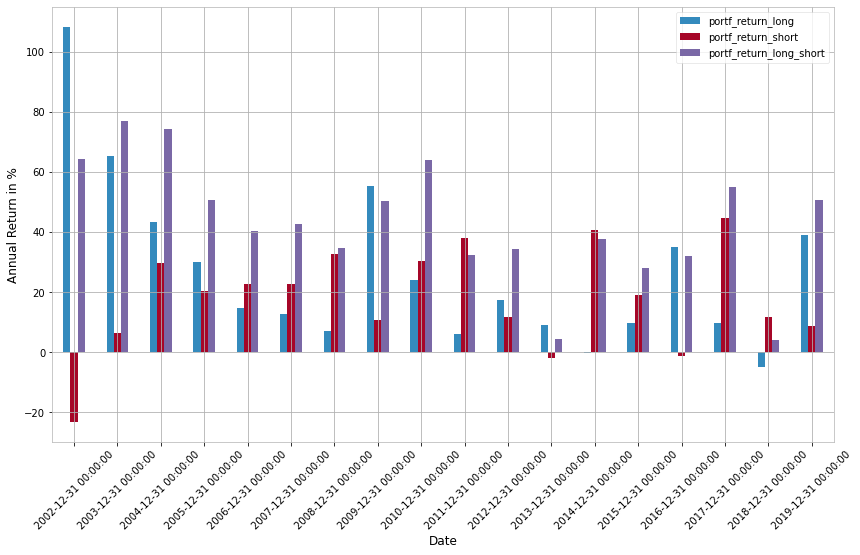

In [538]:
# Annual avg. portfolio returns
annual_returns = ((portfolio[['portf_return_long', 'portf_return_short', 'portf_return_long_short']]+1).resample('Y').mean()-1)*252*100
fig, ax = plt.subplots(figsize=(14,8))
annual_returns.iloc[:-1].plot.bar(ax=ax)
plt.legend()
plt.ylabel('Annual Return in %')
plt.xticks(rotation=45)
plt.show()

In [523]:
portfolio.replace(np.nan, '')[datetime(2002,6,1):].tail(40)

,portf_return_long,portf_return_short,portf_return_long_short,invesment_ratio_long,invesment_ratio_short,n_long,n_short,long_1,long_2,long_3,long_4,long_5,long_6,long_7,long_8,long_9,long_10,short_1,short_2,short_3,short_4,short_5,short_6,short_7,short_8,short_9,short_10
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-11-20,0.003543,-0.027192,-0.023649,1.0,1.0,9,7,MO,JWN,GPS,CRM,TGT,SJM,MDT,INTU,ALL,,CRM,MRK,TGT,HOLX,MGM,INTU,PAYC,,,
2019-11-21,-0.010414,0.006156,-0.004259,1.0,1.0,9,4,TIF,A,AMGN,BBY,SCHW,LOW,CMI,BMY,COP,,LNT,TGT,SCHW,COP,,,,,,
2019-11-22,0.007034,-0.011476,-0.004442,1.0,1.0,6,3,YUM,JWN,GPS,KMB,DUK,INTU,,,,,JWN,ROST,CNP,,,,,,,
2019-11-25,0.006924,-0.024404,-0.01748,1.0,1,5,1,SPGI,TIF,NVDA,RJF,SCHW,,,,,,SCHW,,,,,,,,,
2019-11-26,0.001981,0.002755,0.004735,1.0,1.0,7,6,HBI,BLK,PVH,MAS,BBY,SCHW,CVS,,,,HPE,BLK,SCHW,CVS,DLTR,ADI,,,,
2019-11-27,0.002972,0.002933,0.005905,1.0,1.0,7,2,ADSK,AAP,NEM,BBY,EBAY,UAA,HPQ,,,,BBY,UAA,,,,,,,,
2019-11-29,0.00127,,,1.0,,3,,SPGI,ULTA,WRB,,,,,,,,,,,,,,,,,
2019-12-02,0.007382,-0.011501,-0.004119,1.0,1,5,1,MO,CNC,OXY,CVS,WCG,,,,,,CVS,,,,,,,,,
2019-12-03,-0.003941,-0.002956,-0.006896,1.0,1.0,5,3,NDAQ,WMT,MET,CDNS,MDT,,,,,,NDAQ,WMT,MDT,,,,,,,
